My Gmail inbox was counting close to **30,000**.  Not a pretty number at all, so I decided I should do something about it.

Just like a good data analyst would do, I wanted to clean up my inbox in a **_systematic and data-driven_** manner.

I wanted something easier, quicker, and higher payoff, not something like a full-blown spam classification algorithm using Natural Language Processing.  So I settled on a **50% rule**, where I'll get rid of at least 50% of unnecessary emails.

You'd be surprise to learn that the [pareto principle](https://en.wikipedia.org/wiki/Pareto_principle) of 20% of causes explaining 80% of the effect also holds in my Gmail inbox.  12% of senders accounted for 80% of all emails in my case and **only 18 senders accounted for approximately 50% of all my emails!**

In [14]:
# modules
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LogIn import LogIn
from tqdm import tqdm
from IPython.display import display, HTML

In [2]:
# parse email out from raw data
raw = pd.read_csv("email.csv")
email_parse = [re.search(r'([a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+)', a).group(1) for a in raw.iloc[:,3]]

In [4]:
# extract id and organization name
id_org = [tuple(e.split('@')) for e in email_parse]

In [5]:
# aggregate count by sender and calculate proportion to total
count = Counter(id_org).most_common()
total_count = sum([i[1] for i in count])

collect = []
cumsum = 0
for i in count:
    id_org, c = i
    cumsum += c
    collect.append(("@".join(id_org), c, cumsum, c / total_count, cumsum / total_count))

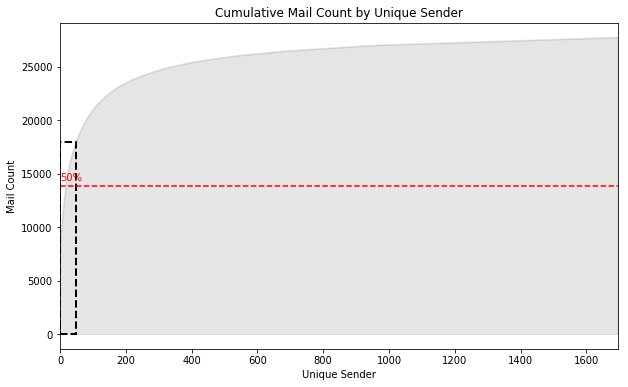

In [6]:
fig, ax = plt.subplots(figsize = (10,6))
p50_count = total_count / 2
item_count = [i[1] for i in collect]
item_cumcount = [i[2] for i in collect]

# chart1: full cdf
ax.plot(range(len(collect)), item_cumcount, alpha = 0.2, color = 'grey')
ax.set_title("Cumulative Mail Count by Unique Sender")
ax.set_xlim(-1, len(count))
ax.set_xlabel("Unique Sender")
ax.set_ylabel("Mail Count")
ax.axhline(p50_count, linestyle = '--', color = 'red')
ax.text(0, p50_count + 500, "50%", color = 'red')
ax.fill_between(range(len(collect)), 0, item_cumcount, alpha = 0.2, color = 'grey')

# create a rectangle patch
rect = patches.Rectangle((0, 0), 50, 18000
                         ,linewidth=2
                         , linestyle = '--'
                         , edgecolor='black'
                         ,facecolor='none')

# add patch to axis
ax.add_patch(rect);

Here you can see, how concentrated my inbox is with regards to unique senders.  There's a steep curve up until the 400th unique sender, meaning that there are 400 email senders that keep cluttering my inbox.  The red dotted horizontal line indicates 50% of my total mail count.

Good to know, but I'm not going to review who those 400 unique senders are.  Instead, I'm going focus on the dotted square portion of the distribution for now.

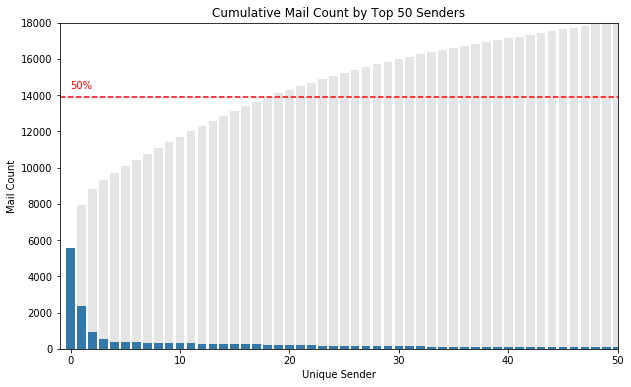

In [7]:
# chart2: magnified pdf and cdf
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(range(len(collect)), item_count)
ax.bar(range(len(collect)), item_cumcount, alpha = 0.2, color = 'grey')
ax.set_title("Cumulative Mail Count by Top 50 Senders")
ax.set_xlim(-1, 50)
ax.set_ylim(0, 18000)
ax.set_xlabel("Unique Sender")
ax.set_ylabel("Mail Count")
ax.axhline(p50_count, linestyle = '--', color = 'red')
ax.text(0, p50_count + 500, "50%", color = 'red');

Zooming into the dotted square portion of the chart above, we can see that **50% of all my emails (~15,000) are from the top 18 most frequent senders**.  Now that's a number that I can manage to review.  Blue bars are the simple mail frequency by unique sender and the grey bars show cumulative numbers of those.

I wonder who the most frequent sender is (first blue bar) as it has sent a whopping 5,000 emails to me so far.  Next up (second blue bar) is no less persistent at around 2,000 emails.  Wonder who that is as well...

In [22]:
# manually look at top N senders
top_n = 18
summary = pd.DataFrame([(i[0][0], i[0][1], i[1]) for i in count[:top_n]]
             , columns = ['name', 'organization', 'count'])

# anonymize names
summary['name'] = np.where(summary['organization'] == 'uchicago.edu'
                           , "XXX"
                           , summary['name'])
# show table
summary.index = summary.index + 1
summary

,name,organization,count
1,newtech-1,meetup.com,5559
2,info,meetup.com,2354
3,hello,mealpal.com,902
4,support,streeteasy.com,523
5,usmail,expediamail.com,371
6,notify,buildinglink.com,361
7,travelocity,ac.travelocity.com,354
8,alert,indeed.com,335
9,Top-Free-Events-Today-announce,meetup.com,323
10,godiva,e.godiva.com,318


Turns out, the two most frequent senders are from ***Meetup***!  Specifically, "newtech-1", which I remember as a New York Tech Meetup, and "info" should be some general update on all Meetup events that I subscribed to.

**Mealpal**, which is a discounted email-based lunch subscription service that I had for a few months also sent me quite some emails, and so did **StreetEasy, Expedia, Uniqlo, Godiva** etc...  Maybe I shouldn't have given my email out to all those websites...

There were some individuals from **UChicago**(alma mater) as well, which I anonymized with "XXX".  Brings back memories.

I think I can delete all emails from the top 18 senders, so I extracted all mail ids corresponding to these senders and used Python and the `imaplib` to automatically delete ~13,000 emails.

Voila! I just reduced my inbox count to half what is was without worrying about deleting any important emails!  Below is a progress bar that shows that I deleted 12,862 emails in 1:20 hours.

In [9]:
# collect all mail ids to delete
delete_set = [i[0] for i in count[:top_n]]
delete_mask = [i in delete_set for i in id_org]
delete_ids = [re.search(r'(\d+)', i).group(1) for i in raw.loc[delete_mask, '0']]

In [10]:
id = "ID" # FILL IN 
pw = "PW" # FILL IN
con = LogIn(id = id, pw = pw).login()

In [29]:
con.select()

for id in tqdm(delete_ids):
    try:
        con.store(id, '+FLAGS', '\\Deleted')
        con.expunge()
    except:
        pass

100%|██████████| 12862/12862 [1:21:03<00:00,  4.23it/s]


<br/>
## More
If you'd like to see the Python script to download email data used in this process, please click [here](https://github.com/ncho-sqd/emailtools/blob/master/main.py).

For Jupyter notebook walking through the email deletion process laid out on this page (after downloaded email data), please click [here](https://github.com/ncho-sqd/emailtools/blob/master/clean_email_inbox.ipynb).